In [1]:
import torch
import yaml
from ml_collections import ConfigDict
from argparse import ArgumentParser
import os

from protein_ebm.model.r3_diffuser import R3Diffuser
from protein_ebm.data.protein_utils import residues_to_features, plot_protein_frame, restypes, restype_order, restype_num
from protein_ebm.model.ebm import ProteinEBM
from protein_ebm.model.boltz_utils import center_random_augmentation
import numpy as np



with open("../protein_ebm/config/base_pretrain.yaml", 'r') as f:
    config = yaml.safe_load(f)
    
config = ConfigDict(config)

# Create models
diffuser = R3Diffuser(config.diffuser)
model = ProteinEBM(config.model, diffuser).cuda()


# Load checkpoint
ckpt = torch.load("../weights/model_1_frozen_1m_md.pt", weights_only=False)



model.load_state_dict({k[len("model."):]: v for k, v in ckpt['state_dict'].items() if k.startswith('model')})

<All keys matched successfully>

In [5]:
import os
import pandas as pd

gymdat = pd.read_csv("../eval_data/proteingym/DMS_substitutions.csv")
stab_files = set(gymdat[gymdat['coarse_selection_type'] == 'Stability']['DMS_filename'])


protgym_path = "../eval_data/proteingym/DMS_ProteinGym_substitutions/"

# just use megascale data for this notebook. Delete 'Tsuboyama' filter for all stability datasets
megascale_files = list(reversed([x for x in os.listdir(protgym_path) if x in stab_files and 'Tsuboyama' in x]))
dats = [pd.read_csv(protgym_path + x) for x in megascale_files]
print(len(megascale_files))
print(megascale_files)

64
['POLG_PESV_Tsuboyama_2023_2MXD.csv', 'YNZC_BACSU_Tsuboyama_2023_2JVD.csv', 'MBD11_ARATH_Tsuboyama_2023_6ACV.csv', 'FKBP3_HUMAN_Tsuboyama_2023_2KFV.csv', 'OBSCN_HUMAN_Tsuboyama_2023_1V1C.csv', 'CBX4_HUMAN_Tsuboyama_2023_2K28.csv', 'SOX30_HUMAN_Tsuboyama_2023_7JJK.csv', 'TCRG1_MOUSE_Tsuboyama_2023_1E0L.csv', 'PIN1_HUMAN_Tsuboyama_2023_1I6C.csv', 'SPG2_STRSG_Tsuboyama_2023_5UBS.csv', 'VILI_CHICK_Tsuboyama_2023_1YU5.csv', 'CUE1_YEAST_Tsuboyama_2023_2MYX.csv', 'PITX2_HUMAN_Tsuboyama_2023_2L7M.csv', 'YAIA_ECOLI_Tsuboyama_2023_2KVT.csv', 'PSAE_PICP2_Tsuboyama_2023_1PSE.csv', 'NUSG_MYCTU_Tsuboyama_2023_2MI6.csv', 'RCD1_ARATH_Tsuboyama_2023_5OAO.csv', 'OTU7A_HUMAN_Tsuboyama_2023_2L2D.csv', 'PR40A_HUMAN_Tsuboyama_2023_1UZC.csv', 'ISDH_STAAW_Tsuboyama_2023_2LHR.csv', 'RD23A_HUMAN_Tsuboyama_2023_1IFY.csv', 'RL20_AQUAE_Tsuboyama_2023_1GYZ.csv', 'RPC1_BP434_Tsuboyama_2023_1R69.csv', 'THO1_YEAST_Tsuboyama_2023_2WQG.csv', 'SBI_STAAM_Tsuboyama_2023_2JVG.csv', 'ODP2_GEOSE_Tsuboyama_2023_1W4G.csv', '

In [3]:
from Bio.PDB import PDBParser
from Bio.PDB.Polypeptide import is_aa
from protein_ebm.data.protein_utils import generate_random_backbone_coords

parser = PDBParser(QUIET=True)
input_data_dicts = []
use_unfolded=True

t=0.1
for f in megascale_files:
    pdb_path = "../eval_data/proteingym/ProteinGym_AF2_structures/" + "_".join(f.split("_")[:2]) + ".pdb"

    structure = parser.get_structure("my_structure", pdb_path) 
    chain = list(structure.get_chains())[0]
    atom_positions, atom_mask, aatype, residue_idx = residues_to_features([r for r in chain.get_residues() if is_aa(r)])
    nres = atom_positions.shape[0]

    num_unfolded = 32
    ca_coords = center_random_augmentation(atom_positions[...,1,:].unsqueeze(0), torch.ones([1, nres])).view([1,-1,3])

    
    single_feats = {
        'r_noisy': ca_coords,
        'aatype': aatype.unsqueeze(0),
        'mask': torch.ones([1,nres]),
        'residue_idx': residue_idx.unsqueeze(0),
        't': torch.tensor([t], dtype=torch.float),
        'selfcond_coords' : ca_coords,
    }

    if use_unfolded:
        unfold_feats = []
        seq =  "".join([restypes[a.item()] for a in aatype])
        unfold_feats = []
        unfold_probs = []
        for i in range(num_unfolded):
            unfolded, _ = generate_random_backbone_coords(seq, uniform_sampling=True)
            unfolded = unfolded[..., 1,:] # just the CAs
            unfolded = center_random_augmentation(unfolded.unsqueeze(0), torch.ones([1, nres])).view([1,-1,3])
            unfold_feats.append(unfolded)

        unfolded = torch.cat(unfold_feats)

    if use_unfolded:
        single_feats['r_noisy'] = torch.cat([single_feats['r_noisy'], unfolded])

        for k in single_feats.keys():
            if k != "r_noisy":
                single_feats[k] = torch.cat([single_feats[k]] * (num_unfolded+1))
        
    
    input_data_dicts.append(single_feats)
    

/orcd/home/002/jamesron/solab/ProteinEBM-cleanup/protein_ebm/data/protein_utils.py:143: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  atom_positions = torch.tensor(atom_positions, dtype=torch.float32)
/orcd/home/002/jamesron/solab/ProteinEBM-cleanup/protein_ebm/data/protein_utils.py:460: UserWarning: Using torch.cross without specifying the dim arg is deprecated.
Please either pass the dim explicitly or simply use torch.linalg.cross.
The default value of dim will change to agree with that of linalg.cross in a future release. (Triggered internally at /pytorch/aten/src/ATen/native/Cross.cpp:62.)
  torch.cross(v2, rotated_dir) * math.sin(dihedral_angle) +


In [4]:
for i in range(len(input_data_dicts)):
    print(input_data_dicts[i]['aatype'].shape)
    print(len(dats[i]['mutated_sequence'][0]))

torch.Size([33, 53])
53
torch.Size([33, 39])
39
torch.Size([33, 66])
66
torch.Size([33, 69])
69
torch.Size([33, 65])
65
torch.Size([33, 50])
50
torch.Size([33, 57])
57
torch.Size([33, 37])
37
torch.Size([33, 39])
39
torch.Size([33, 56])
56
torch.Size([33, 65])
65
torch.Size([33, 52])
52
torch.Size([33, 52])
52
torch.Size([33, 52])
52
torch.Size([33, 68])
68
torch.Size([33, 55])
55
torch.Size([33, 57])
57
torch.Size([33, 42])
42
torch.Size([33, 63])
63
torch.Size([33, 55])
55
torch.Size([33, 44])
44
torch.Size([33, 59])
59
torch.Size([33, 61])
61
torch.Size([33, 41])
41
torch.Size([33, 56])
56
torch.Size([33, 44])
44
torch.Size([33, 69])
69
torch.Size([33, 41])
41
torch.Size([33, 64])
64
torch.Size([33, 40])
40
torch.Size([33, 59])
59
torch.Size([33, 72])
72
torch.Size([33, 52])
52
torch.Size([33, 55])
55
torch.Size([33, 60])
60
torch.Size([33, 71])
71
torch.Size([33, 43])
43
torch.Size([33, 63])
63
torch.Size([33, 56])
56
torch.Size([33, 69])
69
torch.Size([33, 55])
55
torch.Size([33, 

In [6]:
t = 0.1
nrg_log_all = []
for n in range(len(dats)):

    protgym_data = dats[n]
    single_feats = input_data_dicts[n]
    single_feats = {k:v.cuda() for k,v in single_feats.items()}
    
    nrg_log = []
    with torch.no_grad():        
        native_nrg = model.compute_energy(single_feats)['energy']
        if use_unfolded:
            native_nrg = native_nrg[0] - native_nrg[1:].mean()
        
        for i,r in protgym_data.iterrows():
            aatype_mut = torch.tensor([restype_order.get(a, restype_num) for a in r['mutated_sequence']])
            mut_feats = {**single_feats, 'aatype' : aatype_mut.unsqueeze(0).cuda().expand([num_unfolded+1, -1]).cuda() if use_unfolded else aatype_mut.unsqueeze(0).cuda()}

            if use_unfolded:
                energy = model.compute_energy(mut_feats)['energy'] 
                energy = energy[0] - energy[1:].mean() - native_nrg
            else:
                energy = model.compute_energy(mut_feats)['energy']- native_nrg
                
            print(energy)
            nrg_log.append(energy.item())
    
            aa1 = restype_order.get(r['mutant'][0], restype_num)
            print(megascale_files[n] , i, r['mutant'])
            aa2 = restype_order.get(r['mutant'][-1], restype_num)

        nrg_log_all.append(nrg_log)

tensor(-0.9786, device='cuda:0')
POLG_PESV_Tsuboyama_2023_2MXD.csv 0 A1C
tensor(2.1494, device='cuda:0')
POLG_PESV_Tsuboyama_2023_2MXD.csv 1 A1D
tensor(-2.1382, device='cuda:0')
POLG_PESV_Tsuboyama_2023_2MXD.csv 2 A1E
tensor(-3.0488, device='cuda:0')
POLG_PESV_Tsuboyama_2023_2MXD.csv 3 A1F
tensor(2.5162, device='cuda:0')
POLG_PESV_Tsuboyama_2023_2MXD.csv 4 A1G
tensor(-0.2374, device='cuda:0')
POLG_PESV_Tsuboyama_2023_2MXD.csv 5 A1H
tensor(-1.9310, device='cuda:0')
POLG_PESV_Tsuboyama_2023_2MXD.csv 6 A1I
tensor(-0.9624, device='cuda:0')
POLG_PESV_Tsuboyama_2023_2MXD.csv 7 A1K
tensor(-0.2765, device='cuda:0')
POLG_PESV_Tsuboyama_2023_2MXD.csv 8 A1L
tensor(-3.2877, device='cuda:0')
POLG_PESV_Tsuboyama_2023_2MXD.csv 9 A1M
tensor(2.2091, device='cuda:0')
POLG_PESV_Tsuboyama_2023_2MXD.csv 10 A1N
tensor(3.0696, device='cuda:0')
POLG_PESV_Tsuboyama_2023_2MXD.csv 11 A1P
tensor(-2.1763, device='cuda:0')
POLG_PESV_Tsuboyama_2023_2MXD.csv 12 A1Q
tensor(-1.9769, device='cuda:0')
POLG_PESV_Tsuboyama

KeyboardInterrupt: 

In [7]:
len(nrg_log_all)

3

POLG_PESV_Tsuboyama_2023_2MXD.csv
SignificanceResult(statistic=np.float64(-0.7972956864982442), pvalue=np.float64(0.0))


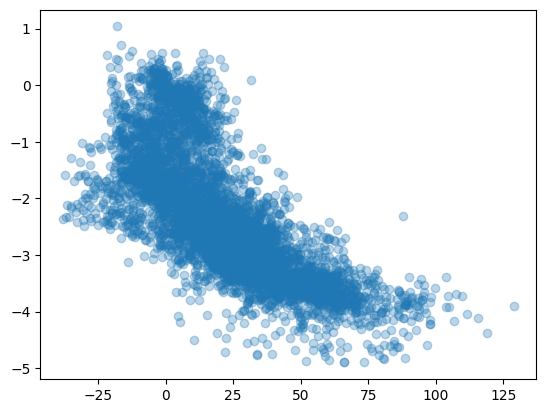

In [8]:
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
i=0
print(megascale_files[i])
plt.scatter(nrg_log_all[i], dats[i]['DMS_score'], alpha=0.3)
print(spearmanr(nrg_log_all[i], dats[i]['DMS_score']))

In [34]:
sprs = []
for i in range(len(megascale_files)):
    sprs.append(spearmanr(nrg_log_all[i], dats[i]['DMS_score'])[0])

print(np.array(sprs).mean())

-0.54016755680165


In [35]:
sprs

[np.float64(-0.8175387331588997),
 np.float64(-0.7120036820316801),
 np.float64(-0.4077819967270749),
 np.float64(-0.3933648760961203),
 np.float64(-0.559065405687883),
 np.float64(-0.6916239794500941),
 np.float64(-0.41415637195540345),
 np.float64(-0.5879403009051966),
 np.float64(-0.5886169275376538),
 np.float64(-0.3262029729750302),
 np.float64(-0.6479652456615876),
 np.float64(-0.43607929606497703),
 np.float64(-0.6507547111918186),
 np.float64(-0.3751054189112261),
 np.float64(-0.747467567499914),
 np.float64(-0.5808368177135959),
 np.float64(-0.4984570365600631),
 np.float64(-0.2304313468977264),
 np.float64(-0.5802863016133748),
 np.float64(-0.3483655866999965),
 np.float64(-0.8066955191638363),
 np.float64(-0.6446496303463687),
 np.float64(-0.4506149365544487),
 np.float64(-0.7622524047501064),
 np.float64(-0.6199071757785777),
 np.float64(-0.10305157930638288),
 np.float64(-0.4500220845826339),
 np.float64(-0.3138420015485308),
 np.float64(-0.7810004981465306),
 np.float64(-